**MovieLens 9000 movies EDA**

Stable benchmark dataset. 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Released 12/2019

https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

## Loading Libraries

1. Installing Pyspark
2. importing seaborn and matplot lib

In [1]:
!pip install -q pyspark

In [7]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count, countDistinct, size, when
from pyspark.sql.functions import regexp_extract, split

sns.set_style('darkgrid')

params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 8),
          'figure.dpi': 100,
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Start PySpark Session
When a spark session is created used the cell below the spark driver memory is allocated a memory of 1GB which is not enough for our dataset.

In [8]:
spark = SparkSession.builder \
    .master('yarn') \
    .config("spark.driver.memory", "10g") \
    .appName('Training') \
    .getOrCreate()

spark = SparkSession.builder.appName("Eda").getOrCreate()

RuntimeError: Java gateway process exited before sending its port number

## Load Dataset & Explore Dataset

Now, let's load the dataset into Spark DataFrames.

In [4]:
# df_movies = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/movies.csv', header=True, inferSchema=True)
# df_ratings = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/ratings.csv', header=True, inferSchema=True)
# df_tags = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/tags.csv', header=True, inferSchema=True)
# df_links = spark.read.csv('links.csv', header=True, inferSchema=True)
# df_genome_scores = spark.read.csv('genome-scores.csv', header=True, inferSchema=True)
# df_genome_tags = spark.read.csv('genome-tags.csv', header=True, inferSchema=True)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/movies.csv.

In [ ]:
df_movies = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/movies.csv', header=True,
                           inferSchema=True)
df_ratings = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/ratings.csv', header=True,
                            inferSchema=True)
df_tags = spark.read.csv('/kaggle/input/movielens-9000-movies-dataset/ml-latest-small/tags.csv', header=True,
                         inferSchema=True)
df_links = spark.read.csv('links.csv', header=True, inferSchema=True)
df_genome_scores = spark.read.csv('genome-scores.csv', header=True, inferSchema=True)
df_genome_tags = spark.read.csv('genome-tags.csv', header=True, inferSchema=True)

'1k2k3k5'

In [ ]:
# unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
# users_sdf = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("DATA SOURCE/users.dat")
# u_cols = users_sdf.columns
# df = users_sdf.select([col(u_cols[i]).alias(unames[i]) for i in range(len(unames))])
# 
# rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
# ratings_sdf = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("DATA SOURCE/ratings.dat")
# df_ratings = ratings_sdf.select([col(u_cols[i]).alias(rnames[i]) for i in range(len(rnames))])
# 
# mnames = ['movie_id', 'title', 'genres']
# movies_sdf = spark.read.format("csv").option("delimiter", "::").option("inferSchema", "true").load("DATA SOURCE/movies.dat")
# df_movies = movies_sdf.select([col(u_cols[i]).alias(mnames[i]) for i in range(len(mnames))])


In [5]:
df_movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+


In [6]:
df_ratings.show(3)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+


In [7]:
df_tags.show(3)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
+------+-------+---------------+----------+


## Data Statistics
Let's calculate some basic statistics about the data.

In [8]:
print('No of Users who rated movies:')
df_ratings.select(countDistinct("userId")).show()

print('No of Movies Rated:')
df_ratings.select(countDistinct("movieId")).show()


print('No of ratings:')
print(df_ratings.count())


print('No of user comments:')
df_tags.select(countDistinct("tag")).show()


print('No of Movies commented by user:')
df_tags.select(countDistinct("movieId")).show()

No of Users who rated movies:


+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   610|
+----------------------+

No of Movies Rated:
+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                   9724|
+-----------------------+

No of ratings:
100836
No of user comments:
+-------------------+
|count(DISTINCT tag)|
+-------------------+
|               1589|
+-------------------+

No of Movies commented by user:
+-----------------------+
|count(DISTINCT movieId)|
+-----------------------+
|                   1572|
+-----------------------+


In [9]:
# # Sample the dataframe
# sample_df = df_combined.select(['title','genres','rating']).sample(False, 0.2, 42)
# # Convert the sample to a Pandas DataFrame
# pandas_df = sample_df.toPandas()

## Data Preparation

We will prepare the data for analysis.

In [10]:
df1 = df_ratings.alias('df1')
df2 = df_tags.alias('df2')
df3 = df_movies.alias('df3')

In [11]:
df1 = df1.drop("timestamp")
df2 = df2.drop("timestamp")

In [12]:
df3.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

## Extracting Movie Release Year
As all movie titles contain the release year in parentheses, let's extract it.

In [13]:
# As all titles contain year, let's extract it

df3 = df3.withColumn("year", regexp_extract(df3["title"], r"\((\d{4})\)", 1))

### Splitting Genres
The genres column contains multiple genres. We will split it into separate columns and convert them to categorical data.

In [14]:
# Step 1: Split genres column into multiple columns
split_expr = split(df3["genres"], "\\|")
for i in range(1, 11):
    df3 = df3.withColumn("genre{}".format(i), split_expr.getItem(i - 1))
    
# Step 2: Convert genre columns to categorical
genre_columns = ["genre{}".format(i) for i in range(1, 11)]
for col_name in genre_columns:
    df3 = df3.withColumn(col_name, col(col_name).cast("string").alias(col_name))

# Step 3: Count genres and create 'genre_count' column
genre_count_expr = sum(when(col(col_name) != "0", 1).otherwise(0) for col_name in genre_columns)
df3 = df3.withColumn("genre_count", genre_count_expr)

In [15]:
df3 = df3.drop('genres')

In [16]:
df3.show(1,False)

+-------+----------------+----+---------+---------+--------+------+-------+------+------+------+------+-------+-----------+
|movieId|title           |year|genre1   |genre2   |genre3  |genre4|genre5 |genre6|genre7|genre8|genre9|genre10|genre_count|
+-------+----------------+----+---------+---------+--------+------+-------+------+------+------+------+-------+-----------+
|1      |Toy Story (1995)|1995|Adventure|Animation|Children|Comedy|Fantasy|null  |null  |null  |null  |null   |5          |
+-------+----------------+----+---------+---------+--------+------+-------+------+------+------+------+-------+-----------+


## Data Analysis

Now, let's perform some data analysis.

### Average Ratings and Counts

In [17]:
# Calculate average rating by movieId
rating_avg = df1.groupBy("movieId").agg(mean("rating").alias("rating_avg"))
rating_avg = rating_avg.withColumnRenamed("movieId", "movieId_avg")

# Calculate rating count by movieId
rating_count = df1.groupBy("movieId").agg(count("rating").alias("rating_count"))
rating_count = rating_count.withColumnRenamed("movieId", "movieId_count")

# Calculate average rating by userId
user_rating = df1.groupBy("userId").agg(mean("rating").alias("user_rating_avg"))
user_rating = user_rating.withColumnRenamed("userId", "userId_avg")

# Calculate rating count by userId
user_count = df1.groupBy("userId").agg(count("rating").alias("user_rating_count"))
user_count = user_count.withColumnRenamed("userId", "userId_count")

# Merge average ratings and counts for movies
df_movie = rating_avg.join(rating_count, col("movieId_avg") == col("movieId_count"), "inner").drop("movieId_count")

# Merge average ratings and counts for users
df_user = user_rating.join(user_count, col("userId_avg") == col("userId_count"), "inner").drop("userId_count")

## Top Users by Rating Count

In [18]:
df_user.sort(col('user_rating_count').desc()).show()

+----------+------------------+-----------------+
|userId_avg|   user_rating_avg|user_rating_count|
+----------+------------------+-----------------+
|       414| 3.391957005189029|             2698|
|       599|2.6420500403551253|             2478|
|       474| 3.398956356736243|             2108|
|       448|2.8473712446351933|             1864|
|       274| 3.235884101040119|             1346|
|       610|3.6885560675883258|             1302|
|        68| 3.233730158730159|             1260|
|       380|3.6732348111658455|             1218|
|       606|3.6573991031390136|             1115|
|       288|3.1459715639810426|             1055|
|       249|3.6964627151051626|             1046|
|       387|3.2585199610516065|             1027|
|       182|3.5112589559877176|              977|
|       307|2.6656410256410257|              975|
|       603|3.5079533404029695|              943|
|       298| 2.363684771033014|              939|
|       177| 3.375553097345133|              904|


## Top Movies by Average Rating

In [19]:
df_movie.sort(col('rating_avg').desc()).show()

+-----------+----------+------------+
|movieId_avg|rating_avg|rating_count|
+-----------+----------+------------+
|      26350|       5.0|           1|
|       3795|       5.0|           1|
|      25887|       5.0|           1|
|     157775|       5.0|           1|
|        633|       5.0|           1|
|      33138|       5.0|           1|
|      67618|       5.0|           1|
|        876|       5.0|           1|
|        496|       5.0|           1|
|      27373|       5.0|           1|
|     113829|       5.0|           1|
|      53578|       5.0|           1|
|     152711|       5.0|           1|
|     118894|       5.0|           1|
|         53|       5.0|           2|
|     160644|       5.0|           1|
|        148|       5.0|           1|
|       8911|       5.0|           1|
|     147300|       5.0|           1|
|      84273|       5.0|           1|
+-----------+----------+------------+


In [20]:
df_movie = df_movie.withColumnRenamed("movieId_avg", "movieId")

In [21]:
# Select relevant columns from df3
dfk = df3.select("movieId", df3["genre1"])

# Merge df2 and dfk using the 'movieId' column
df2 = df2.join(dfk, on="movieId", how="inner")

In [22]:
df2.show()

+-------+------+----------------+---------+
|movieId|userId|             tag|   genre1|
+-------+------+----------------+---------+
|      1|   567|             fun|Adventure|
|      1|   474|           pixar|Adventure|
|      1|   336|           pixar|Adventure|
|      2|   474|            game|Adventure|
|      2|    62|  Robin Williams|Adventure|
|      2|    62|magic board game|Adventure|
|      2|    62|         fantasy|Adventure|
|      3|   289|             old|   Comedy|
|      3|   289|           moldy|   Comedy|
|      5|   474|          remake|   Comedy|
|      5|   474|       pregnancy|   Comedy|
|      7|   474|          remake|   Comedy|
|     11|   474|       president|   Comedy|
|     11|   474|        politics|   Comedy|
|     14|   474|       president|    Drama|
|     14|   474|        politics|    Drama|
|     16|   474|           Mafia|    Crime|
|     17|   474|     Jane Austen|    Drama|
|     21|   474|       Hollywood|   Comedy|
|     22|   474|   serial killer

## Users with the Maximum Tag Count for a Movie

In [23]:
# User movie tags with the maximum count
user_tags = df2.groupBy("userId", "movieId").agg(count("tag").alias("tag_count"))
max_tag_count = user_tags.agg({"tag_count": "max"}).collect()[0][0]
user_tags_max = user_tags.filter(user_tags["tag_count"] == max_tag_count)

# Show the result
user_tags_max.show()

+------+-------+---------+
|userId|movieId|tag_count|
+------+-------+---------+
|   599|    296|      173|
+------+-------+---------+


## User Tag Count

In [24]:
# User tag count
user_tagcount = df2.groupBy("userId").agg(count("tag").alias("tag_count"))
user_tagcount.show(3)

+------+---------+
|userId|tag_count|
+------+---------+
|   513|        3|
|   193|       20|
|   300|        1|
+------+---------+


## Movie Tag Count with Genre Information

In [25]:
# Movie tag count with genre information
movie_tagcount = df2.groupBy("movieId").agg(count("tag").alias("tag_count"))
cols = ["movieId", "genre_count", "genre1"]
dfs = df3.select(cols)
movie_tagcount = movie_tagcount.join(dfs, on="movieId", how="inner")

# Show the result
movie_tagcount.show(3)

+-------+---------+-----------+------+
|movieId|tag_count|genre_count|genre1|
+-------+---------+-----------+------+
|    471|        1|          1|Comedy|
|   1088|        2|          3| Drama|
|   1580|        1|          3|Action|
+-------+---------+-----------+------+


In [26]:
df3 = df3.join(df_movie, on="movieId", how="inner")

# Rename the 'rating' column to 'avg_rating'
df3 = df3.withColumnRenamed("avg_rating", "rating")

# Show the result
df3.show(3)

+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|movieId|               title|year|   genre1|   genre2| genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|       rating_avg|rating_count|
+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|   1580|Men in Black (a.k...|1997|   Action|   Comedy| Sci-Fi|  null|  null|  null|  null|  null|  null|   null|          3|3.487878787878788|         165|
|   2366|    King Kong (1933)|1933|   Action|Adventure|Fantasy|Horror|  null|  null|  null|  null|  null|   null|          4|             3.64|          25|
|   3175| Galaxy Quest (1999)|1999|Adventure|   Comedy| Sci-Fi|  null|  null|  null|  null|  null|  null|   null|          3|             3.58|          75|
+-------+--------------------+----+---------+---------+---

In [27]:
df3.describe().show()

23/09/05 09:52:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+------------------+------------------+---------+---------+--------+-------+-------+--------+--------+--------+-------+-----------------+------------------+------------------+
|summary|          movieId|               title|              year|            genre1|   genre2|   genre3|  genre4| genre5| genre6|  genre7|  genre8|  genre9|genre10|      genre_count|        rating_avg|      rating_count|
+-------+-----------------+--------------------+------------------+------------------+---------+---------+--------+-------+-------+--------+--------+--------+-------+-----------------+------------------+------------------+
|  count|             9724|                9724|              9724|              9724|     6879|     3665|    1335|    348|     77|      14|       2|       1|      1|             9724|              9724|              9724|
|   mean|42245.02437268614|                null|1994.6599732262382|              null|     null|     null|  

In [28]:
df_user.describe().show()

+-------+------------------+------------------+------------------+
|summary|        userId_avg|   user_rating_avg| user_rating_count|
+-------+------------------+------------------+------------------+
|  count|               610|               610|               610|
|   mean|             305.5|3.6572223377474016|165.30491803278687|
| stddev|176.23611056383038|0.4806353173349684|  269.480584387172|
|    min|                 1|             1.275|                20|
|    max|               610|               5.0|              2698|
+-------+------------------+------------------+------------------+


## Visualizations
We will now create visualizations using the data. Please note that we need to convert PySpark DataFrames to Pandas DataFrames for visualization.

In [29]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) #sns.axes_style("whitegrid")

## Plot the distribution of movie release years

In [30]:
# Filter out movies with missing release years
df3 = df3.filter(col("Year").cast("int").isNotNull())
# Create a Pandas DataFrame for release year distribution
pandas_df3 = df3.select("year").toPandas()

/tmp/ipykernel_20/2699452572.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df3.year)


<Axes: xlabel='year', ylabel='Density'>

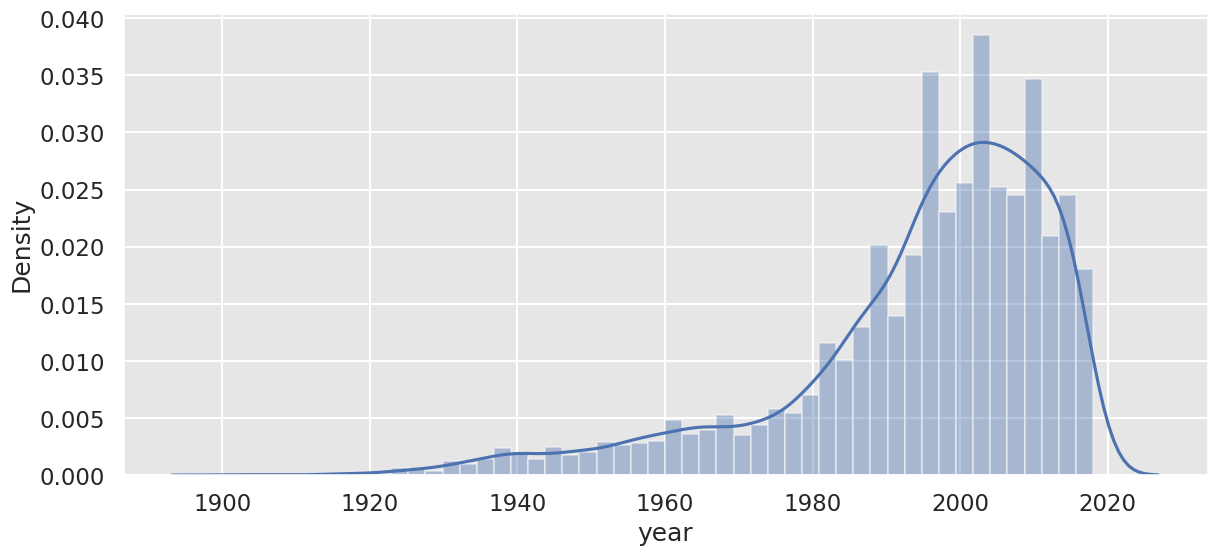

In [31]:
sns.distplot(pandas_df3.year)

/tmp/ipykernel_20/2883013077.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pandas_df3.year)


(1940.0, 2020.0)

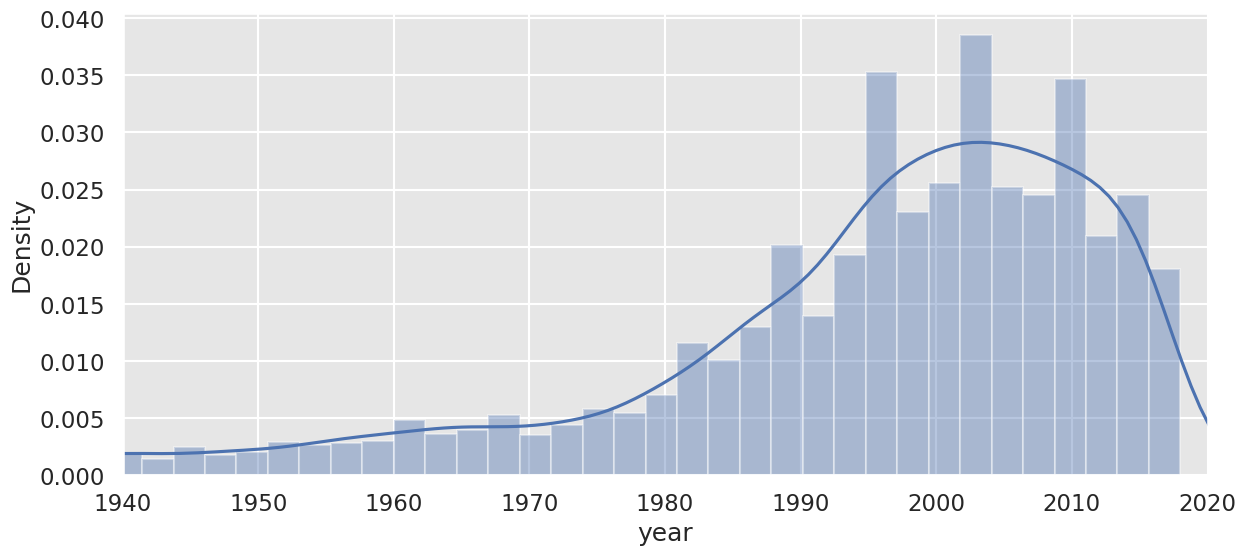

In [32]:
sns.distplot(pandas_df3.year)
plt.xlim(1940, 2020)

## Visualize genre distribution

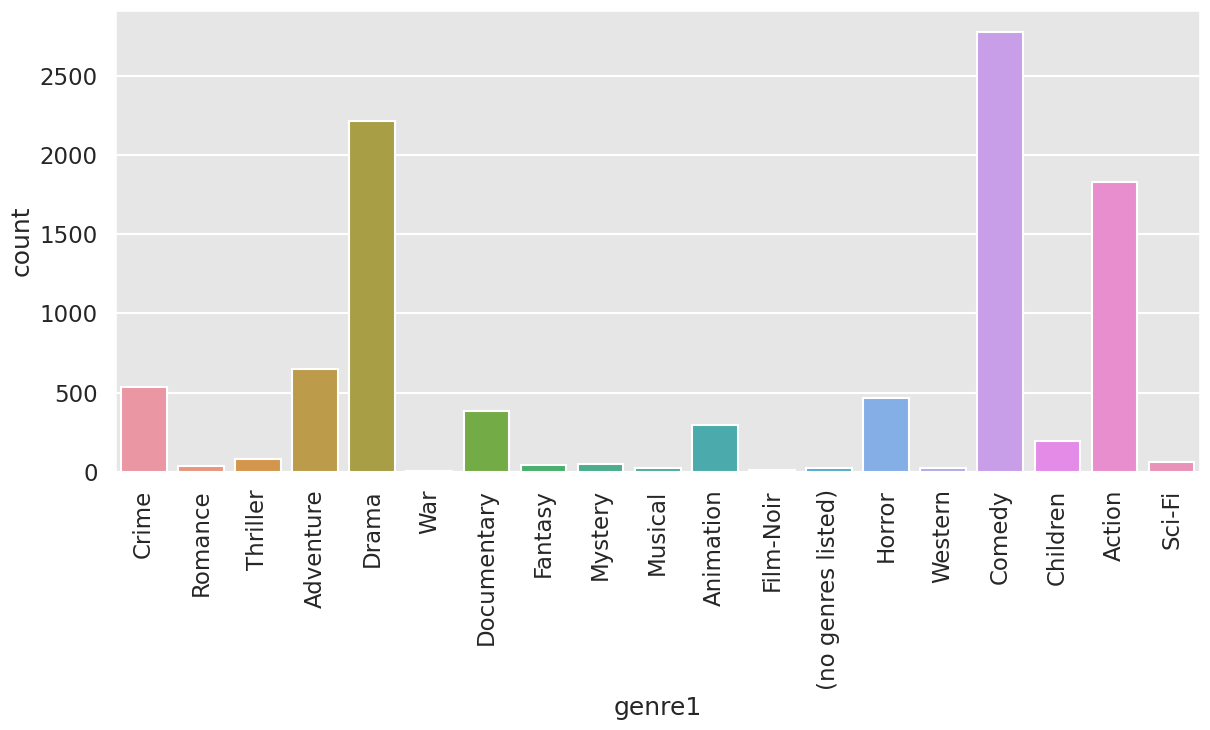

In [33]:
genre = df3.groupBy("genre1").count().toPandas()
sns.barplot(x = genre['genre1'], y=genre['count'])
plt.xticks(rotation=90)
plt.show()

In [34]:
df1.columns

['userId', 'movieId', 'rating']

In [35]:
sample_df1 = df1.select(['userId', 'movieId', 'rating']).sample(False, 0.25, 42)

## Boxen plot of user ratings by movie genre

In [36]:
cols = ['movieId', 'genre1']
b1 = df3[cols]
box_genre = sample_df1.join(b1, on="movieId", how="inner").toPandas()

(-2.0, 7.0)

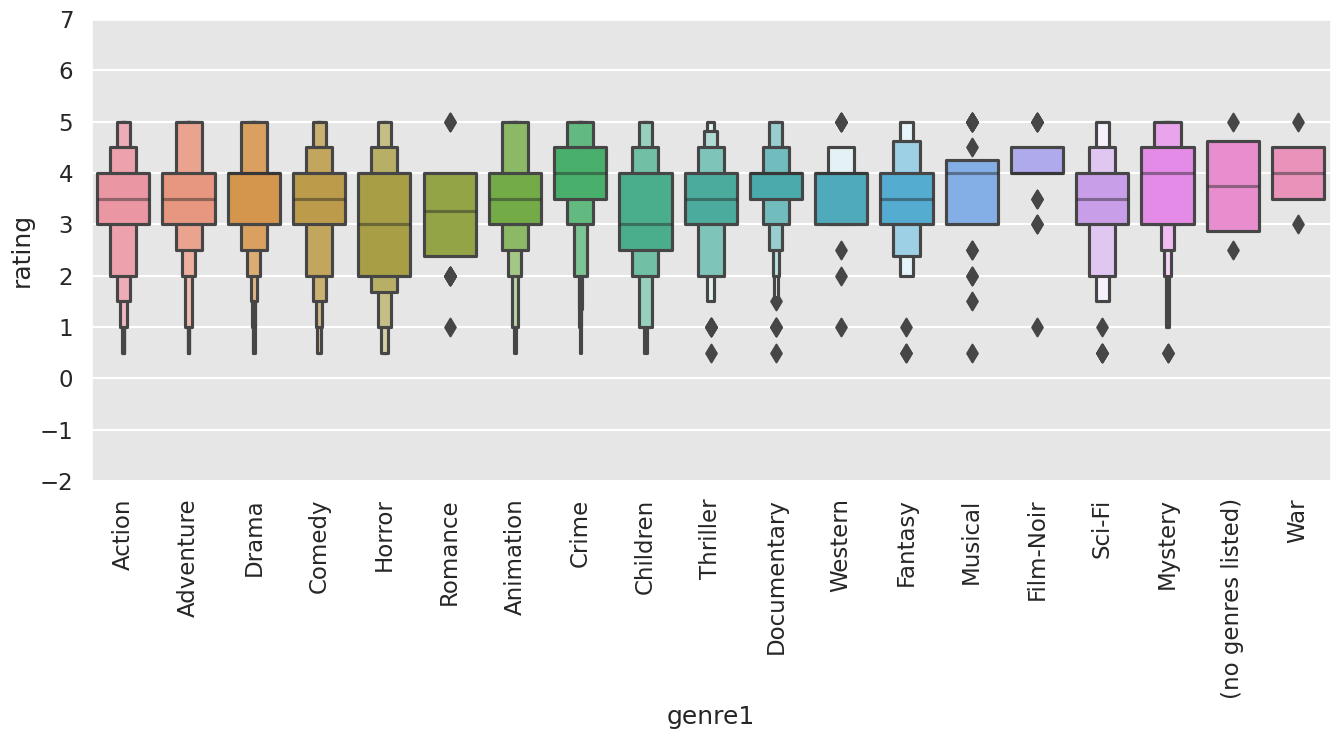

In [37]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.xticks(rotation=90)
plt.ylim(-2, 7)

In [38]:
df3.show(3)

+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|movieId|               title|year|   genre1|   genre2| genre3|genre4|genre5|genre6|genre7|genre8|genre9|genre10|genre_count|       rating_avg|rating_count|
+-------+--------------------+----+---------+---------+-------+------+------+------+------+------+------+-------+-----------+-----------------+------------+
|   1580|Men in Black (a.k...|1997|   Action|   Comedy| Sci-Fi|  null|  null|  null|  null|  null|  null|   null|          3|3.487878787878788|         165|
|   2366|    King Kong (1933)|1933|   Action|Adventure|Fantasy|Horror|  null|  null|  null|  null|  null|   null|          4|             3.64|          25|
|   3175| Galaxy Quest (1999)|1999|Adventure|   Comedy| Sci-Fi|  null|  null|  null|  null|  null|  null|   null|          3|             3.58|          75|
+-------+--------------------+----+---------+---------+---

## Sort by rating_count in descending order and get the top 10 movies

In [39]:
top10_movies = df3.orderBy(col("rating_count").desc()).limit(10)

# Select 'movieId' and 'title' columns
top10_movies = top10_movies.select("movieId", "title")

In [1]:
top10_movies.show()

NameError: name 'top10_movies' is not defined

In [40]:
top10_movies = top10_movies.join(sample_df1, on="movieId", how="inner").toPandas()

In [41]:
print((top10_movies.count(), len(top10_movies.columns)))

(movieId    678
title      678
userId     678
rating     678
dtype: int64, 4)


## Box plot of ratings for the top 10 movies

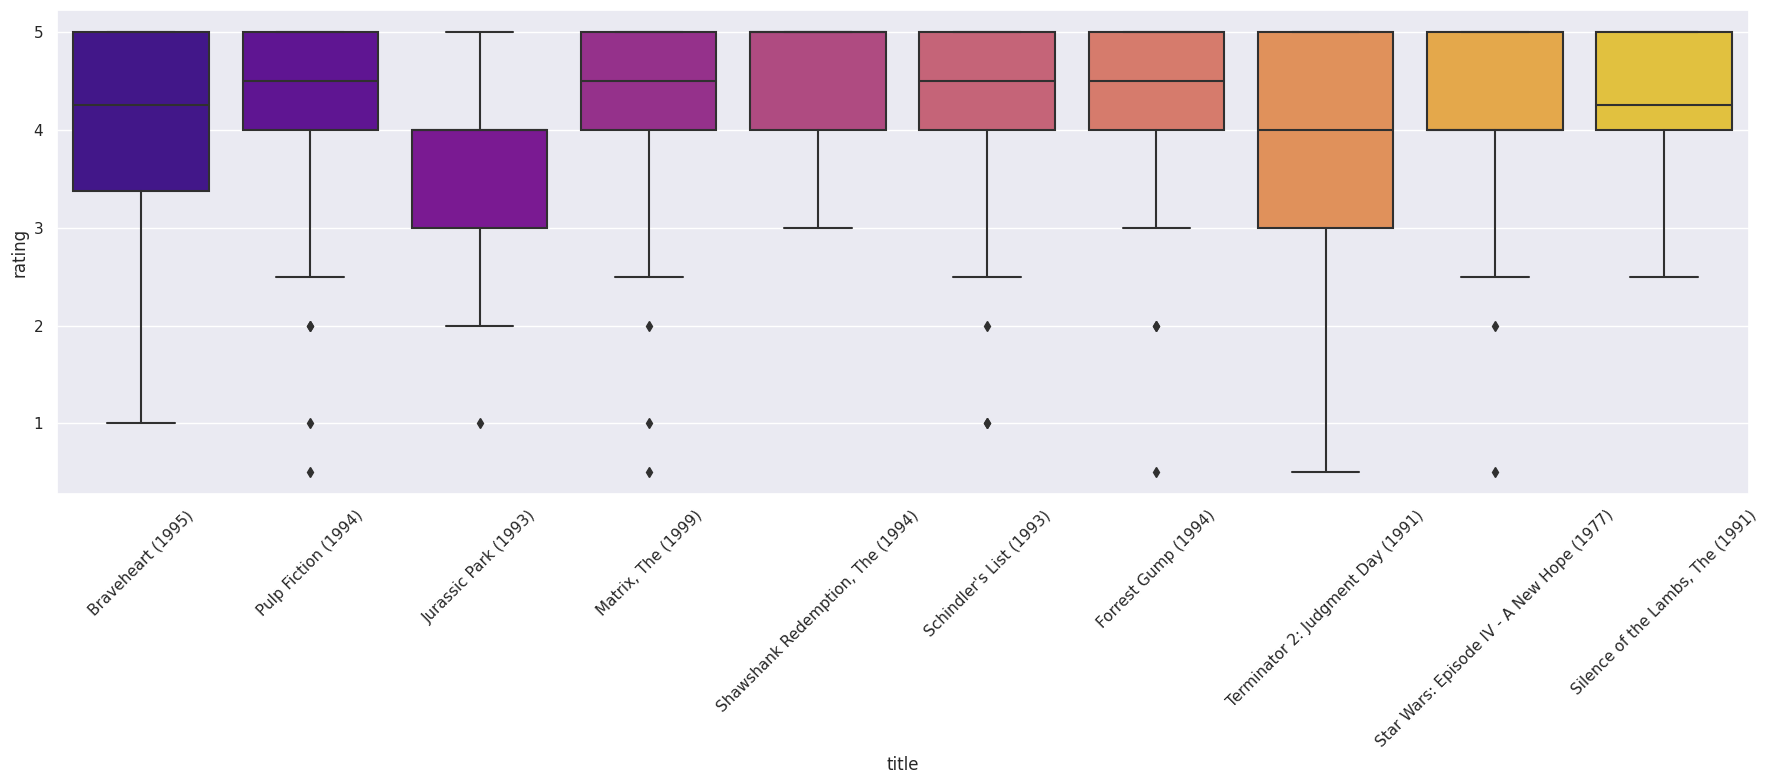

In [42]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10_movies, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()

## Violin plot of ratings for the top 10 movies

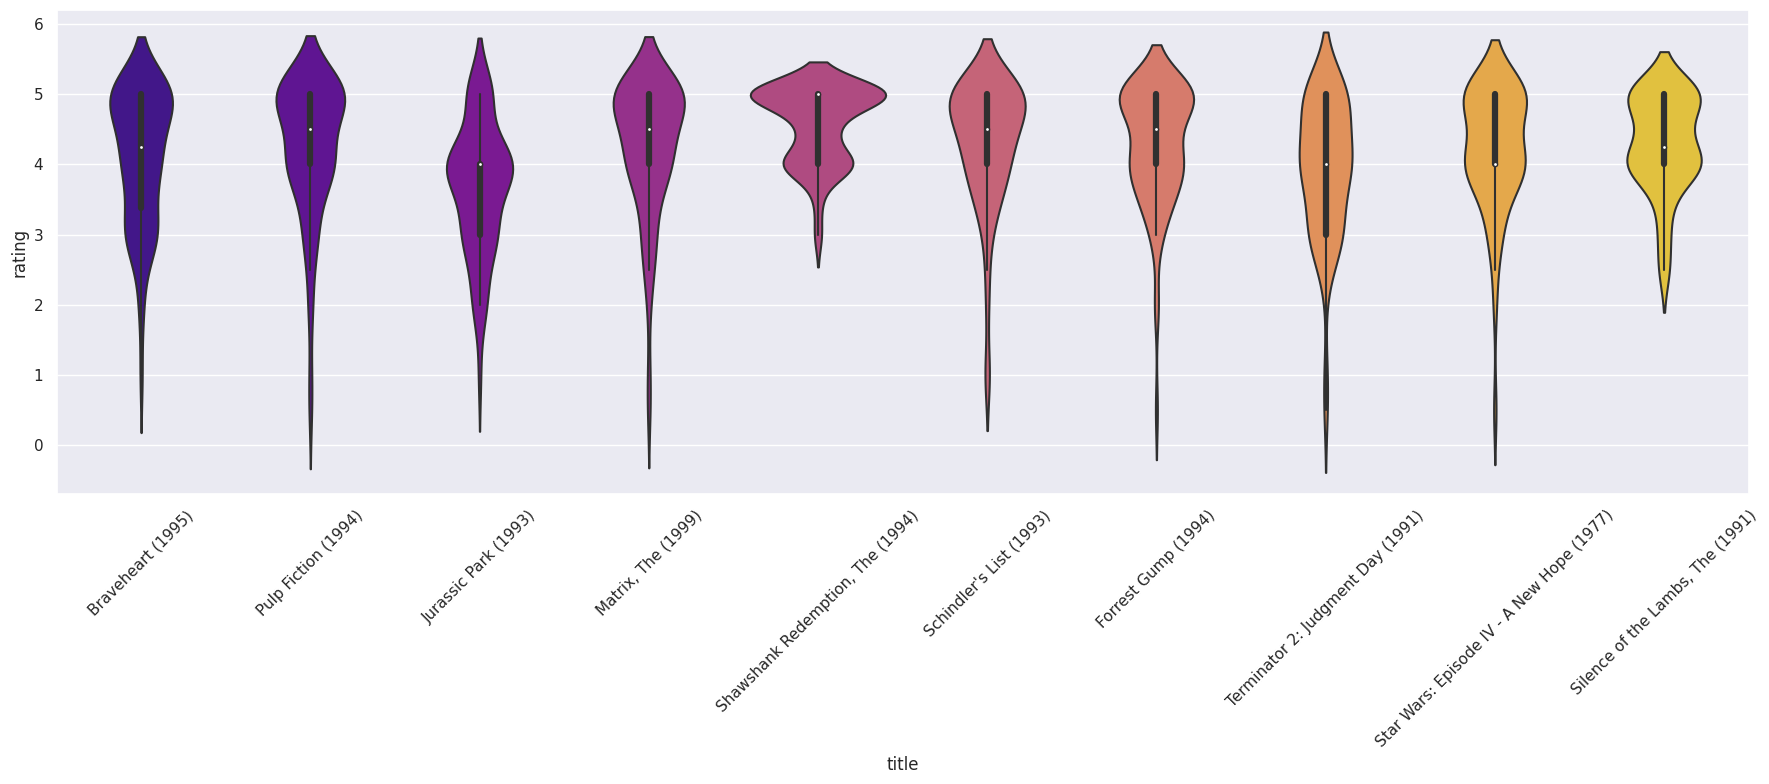

In [43]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.violinplot(x='title', y='rating', data=top10_movies, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()

In [44]:
df_movies.filter(col("title") == "Forrest Gump (1994)").show()

+-------+-------------------+--------------------+
|movieId|              title|              genres|
+-------+-------------------+--------------------+
|    356|Forrest Gump (1994)|Comedy|Drama|Roma...|
+-------+-------------------+--------------------+


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


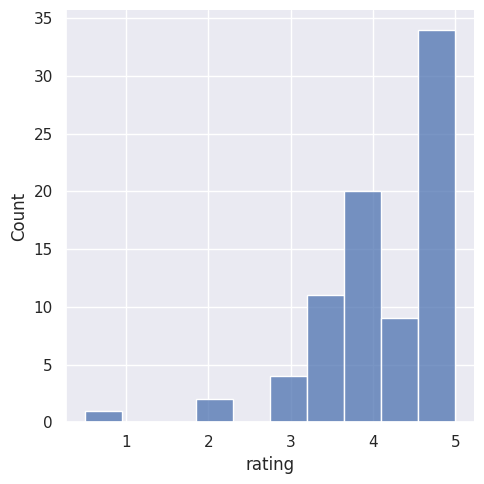

In [45]:
forrest_gump = top10_movies[top10_movies['movieId']==356]
sns.displot(forrest_gump.rating)

## KDE plot of ratings for the top 10 movies

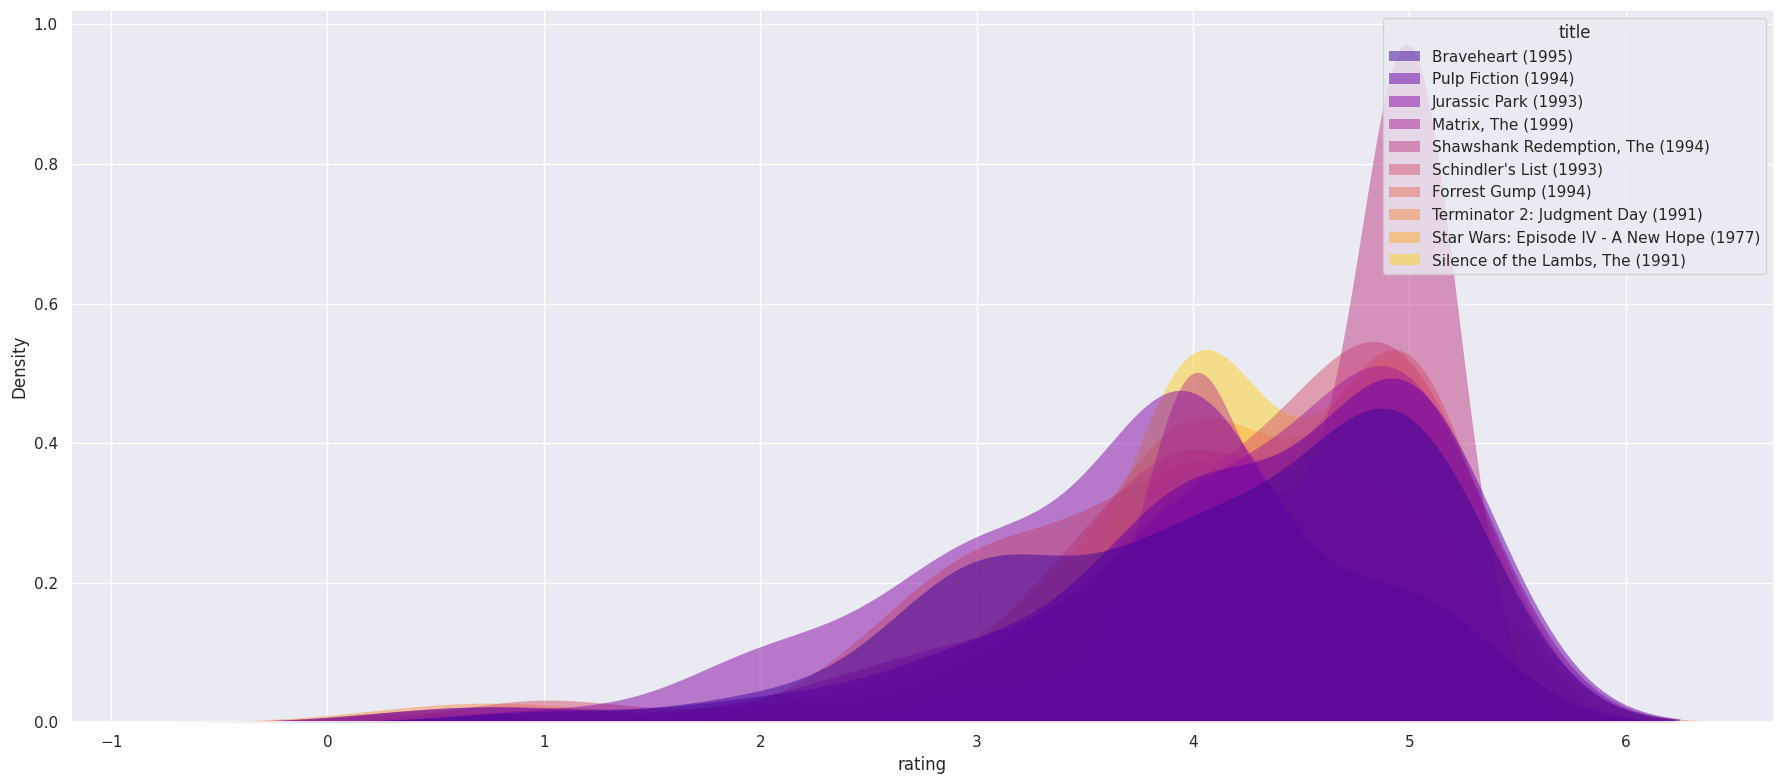

In [46]:
sns.kdeplot(data=top10_movies, x='rating', hue='title', fill=True, common_norm=False, palette="plasma", alpha=.5, linewidth=0,)
plt.tight_layout()

## Stop Spark Session

In [47]:
spark.stop()

## Summary

1. **Dataset Overview:**
   - The MovieLens 25M dataset contains a substantial amount of data, including movie details, user ratings, and user-generated tags.

2. **Data Statistics:**
   - The dataset includes ratings from a large number of users and a diverse set of movies.
   - There are millions of ratings and user-generated tags, indicating significant user interaction with the movies.

3. **Data Preparation:**
   - Data preprocessing steps were applied to make the dataset more amenable to analysis.
   - Release years of movies were extracted from titles, and genres were split into separate columns.
   - The dataset was transformed to calculate average ratings and counts for both movies and users.

4. **User and Movie Tag Analysis:**
   - User tagging behavior was explored, identifying users who contribute the most tags to movies.
   - The number of tags added by each user was calculated.
   - Movie tag counts were analyzed in conjunction with genre information.

5. **Visualizations:**
   - Various visualizations were created to provide insights:
     - Distribution of movie release years revealed that movies from different eras are included in the dataset.
     - Analysis of movie genres showed the popularity of different genres among the movies.
     - Boxen plots provided an understanding of user ratings by movie genre, highlighting genre-specific rating patterns.
     - Box plots and violin plots showcased the distribution of ratings for the top 10 movies by average rating, offering insights into the range and distribution of ratings for these movies.
     - The distribution of ratings for the movie "Forrest Gump" was visualized.
     - Kernel Density Estimation (KDE) plots displayed the distribution of ratings for the top 10 movies.

6. **Conclusion:**
   - The EDA revealed that the MovieLens 25M dataset is rich and diverse, with extensive user interaction and a wide range of movie genres and release years.
   - Users exhibit varying tagging behavior, and certain movies receive more tags than others.
   - The visualizations provided a deeper understanding of user preferences, movie ratings, and genre popularity within the dataset.

This EDA serves as a valuable foundation for further analysis and insights into user behavior, movie recommendations, and the movie industry's trends and patterns.